In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [148]:
df = pd.read_csv('/content/drive/My Drive/Datasets/fraud.csv')
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [150]:
df.columns

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Timestamp', 'Account_Balance', 'Device_Type', 'Location',
       'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label'],
      dtype='object')

In [151]:
df.drop(columns=['Transaction_ID', 'User_ID'], axis=1, inplace=True)

In [152]:
df.head(2)

,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1


In [153]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
df.drop('Timestamp', axis=1, inplace=True)

In [154]:
df['Fraud_Label'].value_counts()

,count
Fraud_Label,
0,33933
1,16067


In [155]:
df.isna().sum().sum()

np.int64(0)

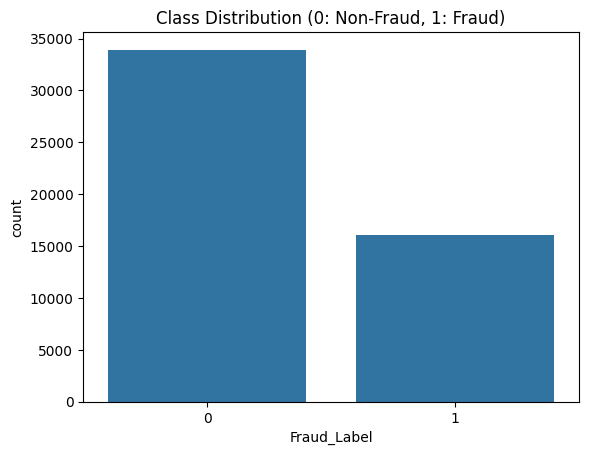

In [156]:
# Visualize class distribution
sns.countplot(x='Fraud_Label', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

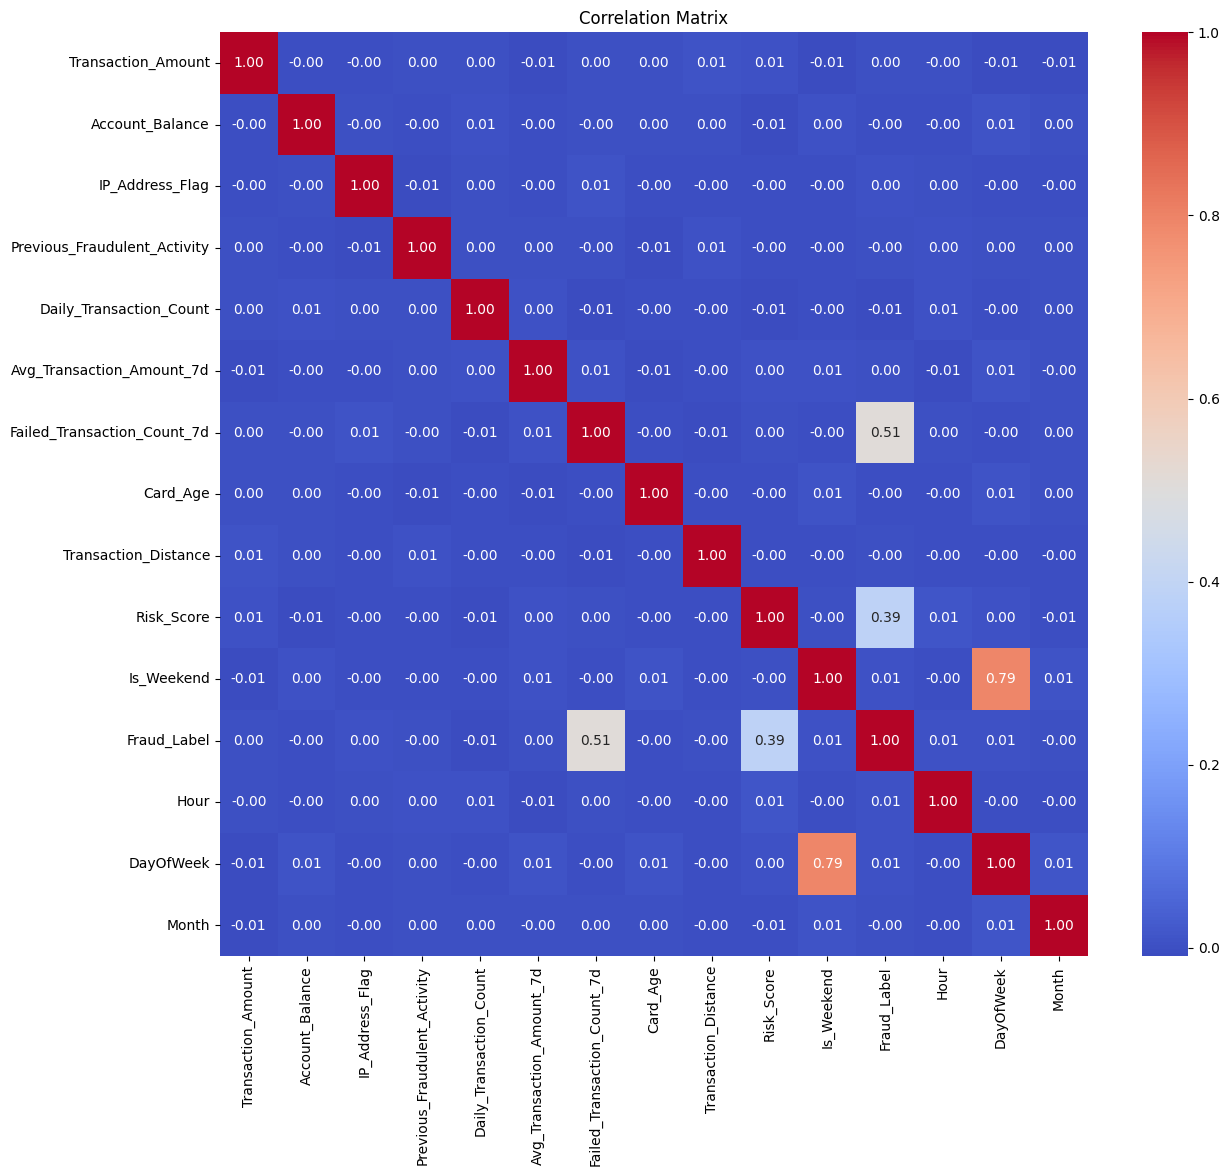

In [157]:
plt.figure(figsize=(14,12))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

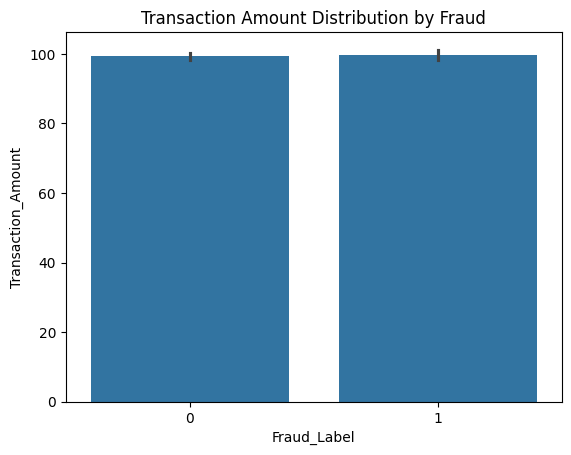

In [158]:
#transaction amount by fraud
sns.barplot(x='Fraud_Label', y='Transaction_Amount', data=df)
plt.title('Transaction Amount Distribution by Fraud')
plt.show()

In [159]:
# Create new features
df['Transaction_Amount_to_Balance'] = df['Transaction_Amount'] / (df['Account_Balance'] + 1)
df['Transaction_Frequency_Ratio'] = df['Daily_Transaction_Count'] / (df['Avg_Transaction_Amount_7d'] + 1)
df['Failed_Transaction_Rate'] = df['Failed_Transaction_Count_7d'] / (df['Daily_Transaction_Count'] + 1)
df['Risk_History_Ratio'] = df['Previous_Fraudulent_Activity'] / (df['Card_Age'] + 1)

# Drop redundant features
df.drop(['Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
         'Failed_Transaction_Count_7d', 'Previous_Fraudulent_Activity'], axis=1, inplace=True)

In [160]:
# Handle categorical variables
cat_cols = ['Transaction_Type', 'Device_Type', 'Location',
            'Merchant_Category', 'Card_Type', 'Authentication_Method']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [161]:
df.head(2)

,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Card_Type,Card_Age,Transaction_Distance,...,Risk_Score,Is_Weekend,Fraud_Label,Hour,DayOfWeek,Month,Transaction_Amount_to_Balance,Transaction_Frequency_Ratio,Failed_Transaction_Rate,Risk_History_Ratio
0,39.79,3,93213.17,0,3,4,0,0,65,883.17,...,0.8494,0,0,19,0,8,0.000427,0.015959,0.375000,0.0
1,1.19,1,75725.25,1,2,0,0,2,186,2203.36,...,0.0959,0,1,4,2,6,0.000016,0.027097,0.285714,0.0


In [163]:
# Split features and target
X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [165]:
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [166]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

In [167]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_res, y_res)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  51 6736]
 [  24 3189]]
              precision    recall  f1-score   support

           0       0.68      0.01      0.01      6787
           1       0.32      0.99      0.49      3213

    accuracy                           0.32     10000
   macro avg       0.50      0.50      0.25     10000
weighted avg       0.56      0.32      0.17     10000



In [168]:
# Initialize and train XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_res, y_res)

# Predictions
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
Accuracy: 0.9519
ROC AUC: 0.9937

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      6787
           1       0.90      0.95      0.93      3213

    accuracy                           0.95     10000
   macro avg       0.94      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [169]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Initialize and train LightGBM
lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    class_weight='balanced',  # Automatically adjusts for imbalance
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit on resampled training data
lgbm.fit(X_res, y_res)

# Predict on test set
y_pred_lgb = lgbm.predict(X_test_scaled)
y_prob_lgb = lgbm.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 27146, number of negative: 27146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4624
[LightGBM] [Info] Number of data points in the train set: 54292, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Performance:
Accuracy: 0.9506
ROC AUC: 0.9939

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      6787
           1       0.90      0.96      0.93      3213

    accuracy                           0.95     10000
   macro avg       0.94      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000



In [170]:
import joblib

# Save model
joblib.dump(xgb, 'fraud_lgbm_model.pkl')

['fraud_lgbm_model.pkl']

In [171]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [172]:
!pip install fastapi uvicorn pyngrok nest-asyncio jinja2

In [173]:
from fastapi import FastAPI, Request, Form
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
import numpy as np
import joblib
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import os

# Enable nested event loops in Colab
nest_asyncio.apply()

# Create templates directory and index.html
os.makedirs("templates", exist_ok=True)

with open("templates/index.html", "w") as f:
    f.write("""
    <!DOCTYPE html>
    <html>
    <head><title>Fraud Detector</title></head>
    <body>
    <h2>Fraud Detection</h2>
    <form method="post" action="/predict">
        <label>Transaction Amount: <input name="Transaction_Amount" type="number" step="any" required></label><br>
        <label>Transaction Type: <input name="Transaction_Type" type="number" required></label><br>
        <label>Account Balance: <input name="Account_Balance" type="number" step="any" required></label><br>
        <label>Device Type: <input name="Device_Type" type="number" required></label><br>
        <label>Location: <input name="Location" type="number" required></label><br>
        <label>Merchant Category: <input name="Merchant_Category" type="number" required></label><br>
        <label>IP Address Flag: <input name="IP_Address_Flag" type="number" required></label><br>
        <label>Card Type: <input name="Card_Type" type="number" required></label><br>
        <label>Card Age: <input name="Card_Age" type="number" required></label><br>
        <label>Transaction Distance: <input name="Transaction_Distance" type="number" step="any" required></label><br>
        <label>Authentication Method: <input name="Authentication_Method" type="number" required></label><br>
        <label>Risk Score: <input name="Risk_Score" type="number" step="any" required></label><br>
        <label>Is Weekend: <input name="Is_Weekend" type="number" required></label><br>
        <label>Hour: <input name="Hour" type="number" required></label><br>
        <label>DayOfWeek: <input name="DayOfWeek" type="number" required></label><br>
        <label>Month: <input name="Month" type="number" required></label><br>
        <button type="submit">Predict</button>
    </form>
    {% if result %}
    <h3>Prediction: {{ result }}</h3>
    {% endif %}
    </body>
    </html>
    """)

# Load trained model and scaler (replace with your real ones if needed)
# For demo, create dummy model and scaler if not already available
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

import numpy as np
X_dummy = np.random.rand(100, 16)
y_dummy = np.random.randint(0, 2, 100)
scaler = StandardScaler().fit(X_dummy)
model = LGBMClassifier().fit(X_dummy, y_dummy)

joblib.dump(model, "fraud_lgbm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# FastAPI setup
app = FastAPI()
templates = Jinja2Templates(directory="templates")

model = joblib.load("fraud_lgbm_model.pkl")
scaler = joblib.load("scaler.pkl")

@app.get("/", response_class=HTMLResponse)
def home(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

@app.post("/predict", response_class=HTMLResponse)
async def predict(request: Request,
                  Transaction_Amount: float = Form(...),
                  Transaction_Type: int = Form(...),
                  Account_Balance: float = Form(...),
                  Device_Type: int = Form(...),
                  Location: int = Form(...),
                  Merchant_Category: int = Form(...),
                  IP_Address_Flag: int = Form(...),
                  Card_Type: int = Form(...),
                  Card_Age: int = Form(...),
                  Transaction_Distance: float = Form(...),
                  Authentication_Method: int = Form(...),
                  Risk_Score: float = Form(...),
                  Is_Weekend: int = Form(...),
                  Hour: int = Form(...),
                  DayOfWeek: int = Form(...),
                  Month: int = Form(...)
):
    input_data = np.array([[Transaction_Amount, Transaction_Type, Account_Balance,
                            Device_Type, Location, Merchant_Category, IP_Address_Flag,
                            Card_Type, Card_Age, Transaction_Distance,
                            Authentication_Method, Risk_Score, Is_Weekend,
                            Hour, DayOfWeek, Month]])

    input_scaled = scaler.transform(input_data)
    pred = model.predict(input_scaled)[0]
    result = "Fraudulent" if pred == 1 else "Legitimate"

    return templates.TemplateResponse("index.html", {"request": request, "result": result})

[LightGBM] [Info] Number of positive: 50, number of negative: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [ ]:
# Setup ngrok tunnel and launch the ap
from pyngrok import ngrok

ngrok.set_auth_token("2IOFgXhO0QOQjBMKF9q9GQ94ZYi_4AvE5TxWXyz2f4Cov5dJ")
public_url = ngrok.connect(8000)
print(f"FastAPI running at: {public_url}")

# Run FastAPI app (non-blocking in Colab)
uvicorn.run(app, host="0.0.0.0", port=8000)


FastAPI running at: NgrokTunnel: "https://eeb7-34-139-122-252.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [879]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     2400:74e0:0:2f33:8c9d:eddd:ccf:97b2:0 - "GET / HTTP/1.1" 200 OK
INFO:     2400:74e0:0:2f33:8c9d:eddd:ccf:97b2:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2400:74e0:0:2f33:8c9d:eddd:ccf:97b2:0 - "POST /predict HTTP/1.1" 200 OK
